In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize

In [3]:
df = pd.read_csv('Avis_clean.csv', index_col=0)

In [4]:
# Renommer la colonne 'Étoiles' en 'Note'
df.rename(columns={'Date complète': 'Date'}, inplace=True)
df.rename(columns={'Étoiles': 'Note'}, inplace=True)


# Afficher le DataFrame pour vérifier le changement
df

,ASIN,Note,Utilisateur,Avis,Pays,Date,Titres
0,B0CS3WDXRV,5.0,Mesut OZBAY,Je suis vraiment satisfait de mon achat de léc...,France,5 décembre 2024,"5,0 sur 5 étoiles Super écran incurvé avec une..."
1,B0CS3WDXRV,5.0,Christopher,Jai acheté cet écran hier pour jouer et films ...,France,10 octobre 2024,"5,0 sur 5 étoiles Impeccable"
2,B0CS3WDXRV,5.0,Kalex,Cet écran MSI G2412F est tout simplement incro...,France,24 décembre 2024,"5,0 sur 5 étoiles Un écran gaming qui dépasse ..."
3,B0CS3WDXRV,4.0,Al... Al...,"Alors....À la base, je viens dun écran Samsung...",France,3 janvier 2024,"4,0 sur 5 étoiles M'ouais....."
4,B0CS3WDXRV,5.0,rene saldana,"Parfait état, conforme au post, recommandé.",Mexique,29 novembre 2024,Excellent article!
...,...,...,...,...,...,...,...
12039,B0D3C6V4KR,3.0,Dirk Grätz,La télévision est bien mais pas de version all...,Allemagne,31 décembre 2024,Les marchandises sont ok
12040,B0D3C6V4KR,5.0,Steve Francis,Bonne qualité pour un prix avantageux,Espagne,12 octobre 2024,Bonne qualité
12041,B0D3C6V4KR,5.0,Raffaele,"Très bien. Produit, expédition, colis etc..",Italie,23 septembre 2024,Parfait.
12042,B0D3C6V4KR,1.0,FMS- Roma,Le produit livré n'est pas localisé pour l'Ita...,Italie,5 octobre 2024,Le produit ne correspond pas à la description


<Axes: >

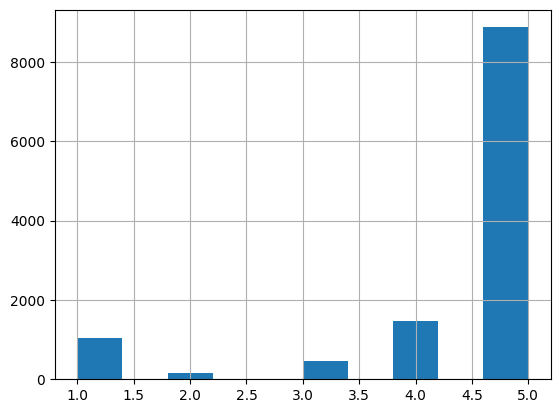

In [5]:
df.Note.hist()

In [8]:
import pandas as pd
from transformers import pipeline
from tqdm import tqdm
import warnings
from concurrent.futures import ThreadPoolExecutor
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Étape 2: Filtrer les avertissements
warnings.filterwarnings("ignore", category=UserWarning, module='transformers')

# Étape 3: Charger le modèle BART de Hugging Face
summarizer = pipeline("summarization", model="facebook/bart-large-cnn",device=-1)

# Étape 4: Fonction pour générer des résumés
def generate_summary(text):
    max_input_length = 1024
    if len(text) > max_input_length:
        text = text[:max_input_length]  # Tronquer le texte si trop long
    summary = summarizer(text, max_length=150, min_length=0, do_sample=False)
    return summary[0]['summary_text'] if summary else "Résumé indisponible"

# Étape 5: Résumer tous les avis par ASIN de manière parallèle
def summarize_for_asin(asin_group):
    asin, group = asin_group
    texte = " ".join(group["Avis"].tolist())  # Rassembler tous les avis d'un produit
    summary = generate_summary(texte)  # Générer un résumé pour cet ASIN
    return asin, summary

def summarize_all_reviews(df):
    print("Je vais résumer tous les avis pour chaque produit (ASIN).")
    
    # Utilisation de ThreadPoolExecutor pour paralléliser le processus
    resumes = {}
    with ThreadPoolExecutor(max_workers=4) as executor:

        results = executor.map(summarize_for_asin, df.groupby("ASIN"))
        
        for asin, summary in tqdm(results, desc="Résumé des avis", unit="produit"):
            resumes[asin] = summary
    
    # Affichage des résumés
    df_resumes = pd.DataFrame(list(resumes.items()), columns=["ASIN", "Résumé"])
    print("\nRésumés des avis :")
    print(df_resumes)

# Lancer la fonction pour résumer tous les avis
summarize_all_reviews(df)


Device set to use cpu


Je vais résumer tous les avis pour chaque produit (ASIN).


Résumé des avis: 44produit [03:58,  3.94s/produit]Your max_length is set to 150, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)
Résumé des avis: 53produit [04:51,  5.50s/produit]


KeyboardInterrupt: 

NameError: name 'df_resumes' is not defined